In [5]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style(style='white')

from IPython import display

import os
import numpy as np
import tensorflow as tf
from tensorflow.contrib.distributions import Normal

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers

spectrogram visualization

In [6]:
n_lags = 2
spect_height = 32
NIN = n_lags*spect_height

# location
datafolder = '/home/AD/kachiem/memmap/memmap_dataset_stimulus/'
visfolder = '/home/AD/kachiem/memmap/memmap_dataset_stimulus_vis/'
x_loc = '%sx_lag%03d.dat' % (datafolder, n_lags)
y_loc = '%sy_lag%03d.dat' % (datafolder, n_lags)
x_loc_vis = '%sx_lag%03d.dat' % (visfolder, n_lags)
y_loc_vis = '%sy_lag%03d.dat' % (visfolder, n_lags)

# get train data
y = np.memmap(x_loc, dtype='float32', mode='r')
num_data_samples = int(len(y) / spect_height)
x_data = np.memmap(x_loc, dtype='float32', mode='r+', shape=(n_lags*spect_height, num_data_samples))
y_data = np.memmap(y_loc, dtype='float32', mode='r+', shape=(spect_height, num_data_samples))

x_data.shape, y_data.shape

((64, 1199696), (32, 1199696))

In [7]:
# function to format input dataset
class Shuffled_memmap_dataset:
    def __init__(self, xfile, yfile, xfile_vis, yfile_vis, vis_ratio=0, valid_ratio=.06):
        y_data = np.memmap(yfile, dtype='float32', mode='r')
        self.num_data_samples = int(len(y_data) / spect_height)
       
        y_data_vis = np.memmap(yfile_vis, dtype='float32', mode='r')
        self.num_data_samples_vis = int(len(y_data_vis) / spect_height)
       
        self.x_data = np.memmap(xfile, dtype='float32', mode='r', shape=(n_lags*spect_height, self.num_data_samples))
        self.y_data = np.memmap(yfile, dtype='float32', mode='r', shape=(spect_height, self.num_data_samples))
       
        self.x_data_vis = np.memmap(xfile_vis, dtype='float32', mode='r', shape=(n_lags*spect_height, self.num_data_samples_vis))
        self.y_data_vis = np.memmap(yfile_vis, dtype='float32', mode='r', shape=(spect_height, self.num_data_samples_vis))
               
        #self.num_vis_samples = int(self.num_data_samples*vis_ratio)
        self.num_valid_samples = int(self.num_data_samples*valid_ratio)
        #vis_start = np.random.randint(self.num_data_samples - self.num_vis_samples)
       
        #self.vis_idxs = np.arange(vis_start, vis_start + self.num_vis_samples)
        #self.data_idxs = np.delete(np.arange(self.num_data_samples), self.vis_idxs)
        self.data_idxs_vis = np.arange(self.num_data_samples_vis)
        self.data_idxs = np.arange(self.num_data_samples)
        #self.num_data_samples -= self.num_vis_samples
       
        np.random.shuffle(self.data_idxs)
        self.valid_idxs, self.data_idxs = np.split(self.data_idxs, [self.num_valid_samples])
        self.num_data_samples -= self.num_valid_samples
           
    def get_data(self, idx):
        return self.x_data[:, idx].T, self.y_data[:, idx].T
   
    def data_iterator(self, batch_size=64):
        np.random.shuffle(self.data_idxs)
        for batch_idx in range(0, self.num_data_samples, batch_size):
            shuff_idx = self.data_idxs[batch_idx:batch_idx+batch_size]
            yield self.get_data(shuff_idx)
   
    def valid_set(self):
        return self.get_data(self.valid_idxs)
   
    def valid_iterator(self, batch_size=64):
        for batch_idx in range(0, self.num_valid_samples, batch_size):
            valid_idx = self.valid_idxs[batch_idx:batch_idx+batch_size]
            yield self.get_data(valid_idx)
   
    def vis_set(self):
        #return self.get_data(self.vis_idxs)
        return self.get_data(self.data_idxs_vis)
   
    #def vis_iterator(self, start=0, end=None, batch_size=1):
    #    if end is None:
    #        end = self.num_vis_samples
    #    for batch_idx in range(start, end, batch_size):
    #        data_idx = self.vis_idxs[batch_idx:batch_idx+batch_size]
    #        yield self.get_data(data_idx)
           
    def vis_iterator(self, start=0, end=None, batch_size=1):
        if end is None:
            end = self.num_data_samples_vis
        for batch_idx in range(start, end, batch_size):
            data_idx = self.data_idxs_vis[batch_idx:batch_idx+batch_size]
            yield self.get_data(data_idx)

dataset = Shuffled_memmap_dataset(x_loc, y_loc, x_loc_vis, y_loc_vis)


In [8]:
## Get visualization dataset
vis_x, vis_y = dataset.vis_set()
# took a subset of test set for visualization
start = 3000
end = start + 1000
sub_vis_x = vis_x[start:end, :]
sub_vis_y = vis_y[start:end, :]

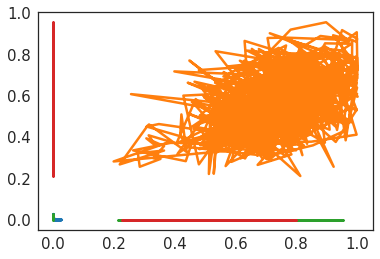

In [9]:
plt.plot(sub_vis_x, sub_vis_y)